In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Namespace(aux_loss=False, backbone='resnet50', batch_size=1, bbox_loss_coef=5, cache_mode=False, clip_max_norm=0.1, cls_loss_coef=2, coco_panoptic_path=None, coco_path='/root/dataset_clp/', dataset_file='coco', dec_layers=6, dec_n_points=4, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=1024, dropout=0.1, enc_layers=6, enc_n_points=4, epochs=100, eval=True, faster_rcnn=True, focal_alpha=0.25, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0002, lr_backbone=2e-05, lr_backbone_names=['backbone.0'], lr_drop=40, lr_drop_epochs=None, lr_linear_proj_mult=0.1, lr_linear_proj_names=['reference_points', 'sampling_offsets'], mask_loss_coef=1, masks=False, nheads=8, num_feature_levels=4, num_queries=300, num_workers=8, output_dir='result', position_embedding='sine', position_embedding_scale=6.283185307179586, remove_difficult=False, resume='/root/Deformable-DETR/exps/r50_deformable_detr/checkpoint0099.pth', seed=42, set_cost_bbox=5, set_cost_class=2, set_cost_giou=2

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:565: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/BinaryOps.cpp:506.)
  return torch.floor_divide(self, other)


torch.Size([1, 512, 100, 100])
torch.Size([1, 1024, 50, 50])
torch.Size([1, 2048, 25, 25])
mask_flatten
torch.Size([1, 13294])
spatial_shapes
torch.Size([4, 2])
torch.Size([1, 13294, 256])
cuda


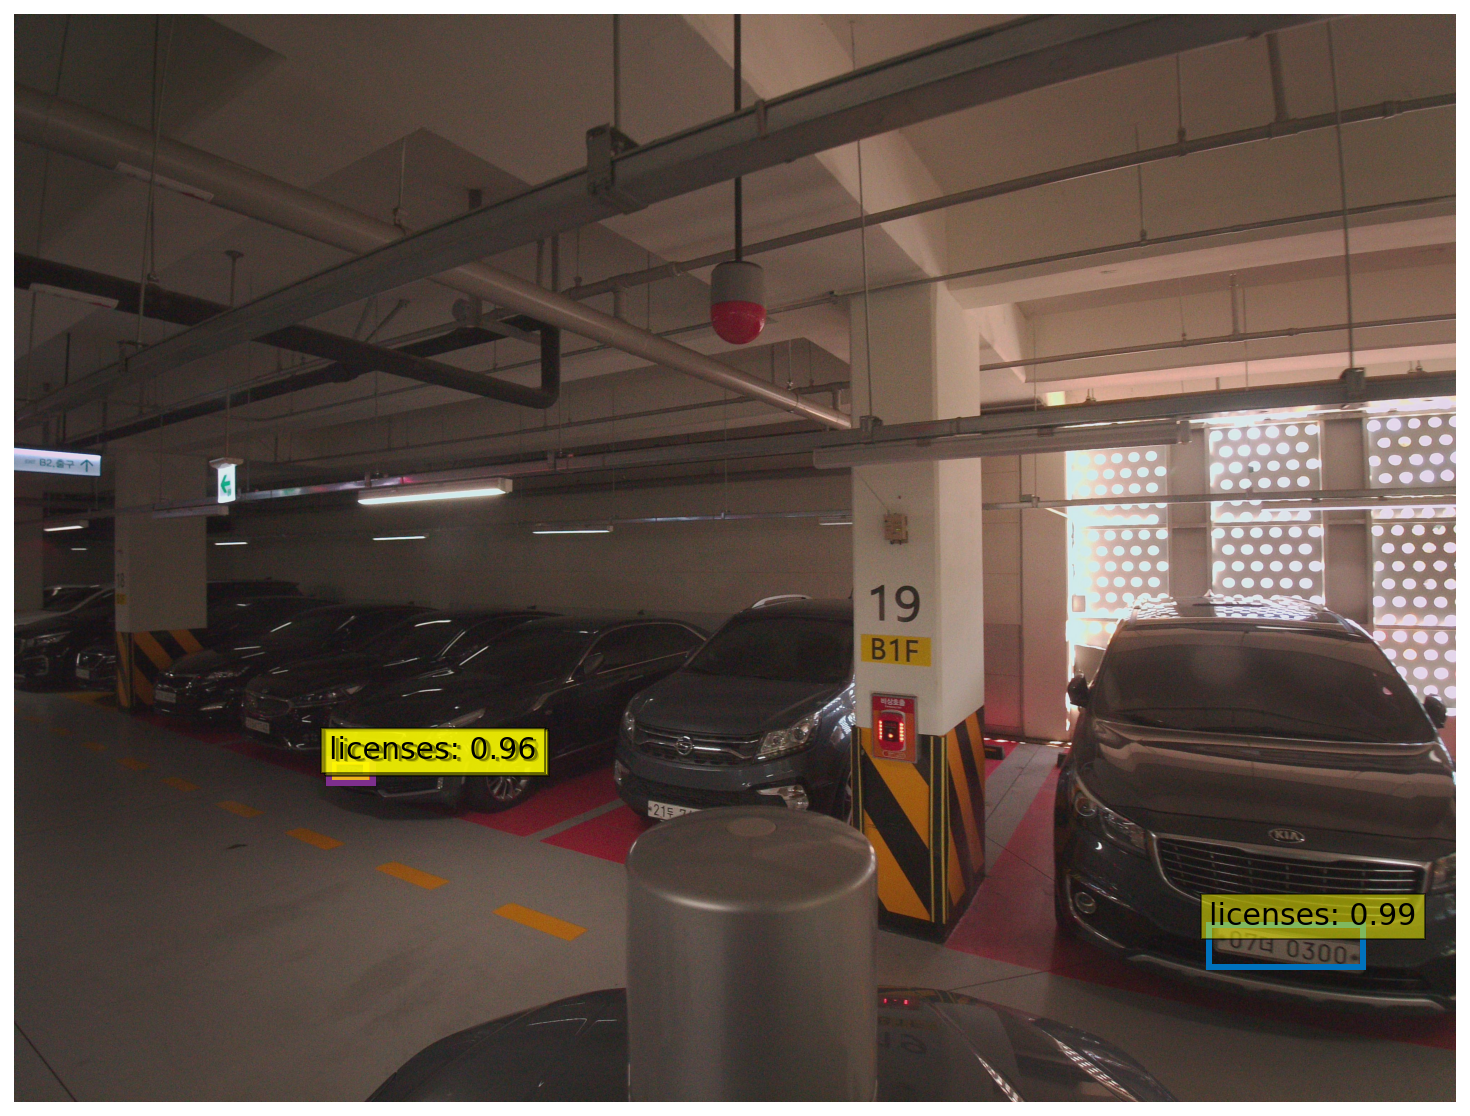

In [1]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import argparse
import test
import torchvision
from pathlib import Path
from models.deformable_detr import build
from models.deformable_detr import DeformableDETR
from util.misc import NestedTensor
# from models.backbone import DETR
# from models.backbone import DETR
torch.set_grad_enabled(False);

# COCO classes
CLASSES = [
    'N/A', 'licenses'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize((800,800)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size, device):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32, device=device)
    return b
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# from models.backbone import build_backbone
command ="--dataset_file coco --with_box_refine --two_stage --faster_rcnn --batch_size 1 --eval --no_aux_loss --coco_path /root/dataset_clp/ --output_dir result --resume /root/Deformable-DETR/exps/r50_deformable_detr/checkpoint0099.pth --num_workers=8"

parser = argparse.ArgumentParser('Deformable DETR training and evaluation script', parents=[test.get_args_parser()])
args = parser.parse_args(command.split())
print(args)

device = torch.device('cuda')

# im = Image.open('/root/dataset_clp/large_clp.jpg')
# im = Image.open('/root/pytorch-faster-rcnn/imgs/20220901_105526_01.jpg')
im = Image.open('/root/pytorch-faster-rcnn/imgs/20220901_105528_41.jpg')
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)
print(img.shape)
img = img.to(device)  # 입력 데이터를 CUDA 디바이스로 이동

# FasterRCNN
# from utils_rcnn.train_utils import create_model
# from configs.test_config import test_cfg
# faster_rcnn = create_model(num_classes=test_cfg.num_classes)
# faster_rcnn.to(args.device)
# weights = test_cfg.model_weights

# checkpoint = torch.load(weights, map_location='cpu')
# faster_rcnn.load_state_dict(checkpoint['model'])
# faster_rcnn.eval()
# predictions, bf_nms_boxes, pred_boxes = faster_rcnn(img)
print(img.shape)
# Deformable DETR
model, criterion, postprocessors = build(args)
# state_dict = torch.load('/root/Deformable-DETR/exps/r50_deformable_detr_plus_iterative_bbox_refinement_plus_plus_two_stage/checkpoint0044.pth')
state_dict = torch.load('/root/Deformable-DETR/exps/r50_deformable_detr_plus_iterative_bbox_refinement_plus_plus_two_stage/checkpoint0044.pth')
model.load_state_dict(state_dict['model'])
model.to(device)

# propagate through the model
outputs = model(img, None)

# keep only predictions with 0.7+ confidence
probas = outputs[0]['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

print(device)
# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs[0]['pred_boxes'][0, keep], im.size, device)
plot_results(im, probas[keep], bboxes_scaled)

# Detection - Visualize encoder-decoder multi-head attention weights
Here we visualize attention weights of the last decoder layer. This corresponds to visualizing, for each detected objects, which part of the image the model was looking at to predict this specific bounding box and class.

We will use hooks to extract attention weights (averaged over all heads) from the transformer.

In [2]:
def hooking(model, layer=-1) :# use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights, dec_reference_points = [], [], [], []
    encoder_layer = layer
    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.transformer.encoder.layers[encoder_layer].self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[0])
        ),
        model.transformer.decoder.layers[-1].cross_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
        model.transformer.decoder.register_forward_hook(
            lambda self, input, output: dec_reference_points.append(output[1])
        ),
    ]

    # propagate through the model
    outputs = model(img, None)

    for hook in hooks:
        hook.remove()
        

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[0]
    dec_attn_weights = dec_attn_weights[0]

In [3]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights, dec_reference_points, init_refer_bf_two_stage = [], [], [], [], []
encoder_layer = -1
hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[encoder_layer].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[0])
    ),
    model.transformer.decoder.layers[-1].cross_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[0])
    ),
    model.transformer.register_forward_hook(
        lambda self, input, output: dec_reference_points.append(output[2])
    ),
    model.transformer.register_forward_hook(
        lambda self, input, output: init_refer_bf_two_stage.append(output[1])
    ),
]

# propagate through the model
outputs = model(img, None)

for hook in hooks:
    hook.remove()
    

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]
dec_reference_points = dec_reference_points[0]
init_refer_bf_two_stage = init_refer_bf_two_stage[0]
print(f'dec_attn_weights {dec_attn_weights.shape}')
print(f'dec_rf_point {dec_reference_points.shape}')
print(f'init_refer_bf_two_stage {init_refer_bf_two_stage.shape}')

# import seaborn as sns
# sns.heatmap(dec_attn_weights[0][0, 0].cpu(), cmap='viridis')
# plt.show()

torch.Size([1, 512, 100, 100])
torch.Size([1, 1024, 50, 50])
torch.Size([1, 2048, 25, 25])
mask_flatten
torch.Size([1, 13294])
spatial_shapes
torch.Size([4, 2])
torch.Size([1, 13294, 256])
dec_attn_weights torch.Size([1, 300, 256])
dec_rf_point torch.Size([6, 1, 300, 4])
init_refer_bf_two_stage torch.Size([1, 300, 4])


Now let's visualize them

Decoder 전 two-stage에서 추천해주는 바운딩박스

In [50]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# 원본 이미지의 크기를 가져옵니다.
dec_reference_points = dec_reference_points.detach().cpu()
img_width, img_height = im.size
# 모든 head에 대해
for i in range(6):
    fig, axs = plt.subplots(1, figsize=(10, 10))
    axs.imshow(im)

    # 각 바운딩 박스에 대해
    for idx, bbox in enumerate(dec_reference_points[i, 0]):
        # 상대 좌표를 원본 이미지의 크기에 맞게 변환
        x, y, w, h = bbox
        x = x * img_width
        w = w * img_width
        y = y * img_height
        h = h * img_height
        
        # 변환된 좌표를 이용해 사각형 패치 생성
        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')

        # 사각형 패치 추가
        axs.add_patch(rect)
        if idx == 299 : 
            print(im.size)
            print(dec_reference_points[i, 0].shape)
            print('layer pass')

    # 이미지 저장
    plt.title(f"layer_{i}")
    plt.savefig(f'/root/Deformable-DETR/result_decoder_boxes/parking_bbox_image_layer_{i}.png')
    plt.close()


(4032, 3040)
torch.Size([300, 4])
layer pass
(4032, 3040)
torch.Size([300, 4])
layer pass
(4032, 3040)
torch.Size([300, 4])
layer pass
(4032, 3040)
torch.Size([300, 4])
layer pass
(4032, 3040)
torch.Size([300, 4])
layer pass
(4032, 3040)
torch.Size([300, 4])
layer pass


Decoder를 통과하고 난 후, 바운딩 박스 시각화화

In [52]:

# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from PIL import Image
# import numpy as np

# 원본 이미지의 크기를 가져옵니다.
# init_refer_bf_two_stage -> [1,300,4]
init_refer_bf_two_stage = init_refer_bf_two_stage.detach().cpu()
img_width, img_height = im.size
# 모든 head에 대해
fig, axs = plt.subplots(1, figsize=(10, 10))
axs.imshow(im)

# 각 바운딩 박스에 대해
for idx, bbox in enumerate(init_refer_bf_two_stage[0]):
    # 상대 좌표를 원본 이미지의 크기에 맞게 변환
    x, y, w, h = bbox
    x = x * img_width
    w = w * img_width
    y = y * img_height
    h = h * img_height
    
    # 변환된 좌표를 이용해 사각형 패치 생성
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')

    # 사각형 패치 추가
    axs.add_patch(rect)
    if idx == 299 : 
        print(im.size)
        print(init_refer_bf_two_stage[0].shape)
        print('layer pass')

    # 이미지 저장
plt.title(f"two-stage-region-proposal")
plt.savefig(f'/root/Deformable-DETR/result_decoder_boxes/two-stage-region-proposal.png')
plt.close()


(4032, 3040)
torch.Size([300, 4])
layer pass


In [ ]:
# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]
print(len(bboxes_scaled))
print(type(dec_attn_weights))
fig, axs = plt.subplots(ncols=len(bboxes_scaled)+1, nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    print(dec_attn_weights[0, idx].shape)
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(16, 16))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

# Visualize encoder self-attention weights

In this section we visualize the model's self-attention. This allows us to gain intuition on how the model encodes the objects. In particular, we see from the attention response maps that the encoder already participate to the instance separation process.

Let's start by visualizing the shape of the encoder self-attention:

In [22]:
# output of the CNN
f_map = conv_features['0']
print("Encoder attention:      ", enc_attn_weights[0].shape)
print("Feature map:            ", f_map.tensors.shape)
# for feature in conv_features :
#     print(feature)

Encoder attention:       torch.Size([13294, 256])
Feature map:             torch.Size([1, 512, 100, 100])


As we can see, the self-attention is a square matrix of size `[H * W, H * W]`, where `H` and `W` are the sizes of the feature map, so we reshape it so that it has a more interpretable representation of `[H, W, H, W]`.

seaborn을 이용한 Attention weight 시각화 코드 생성

torch.Size([1, 512, 100, 100])
torch.Size([1, 1024, 50, 50])
torch.Size([1, 2048, 25, 25])
mask_flatten
torch.Size([1, 13294])
spatial_shapes
torch.Size([4, 2])
torch.Size([1, 13294, 256])


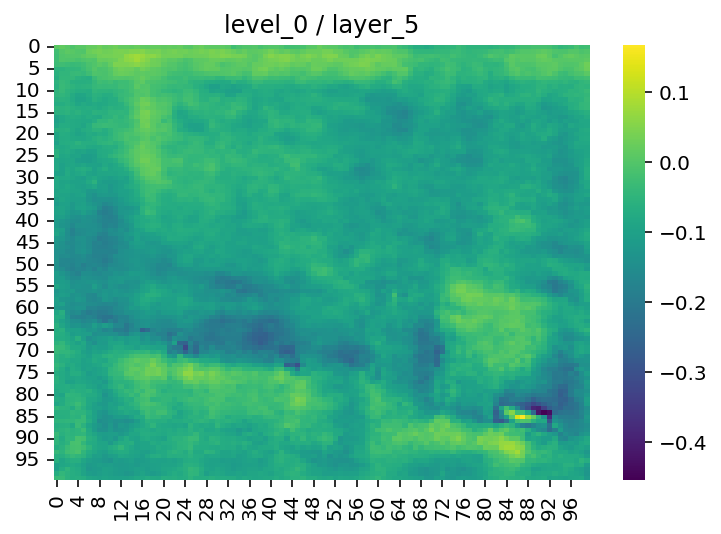

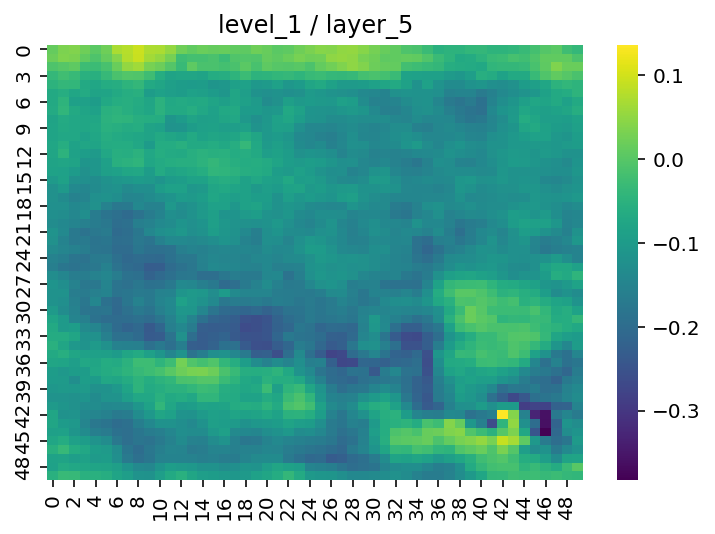

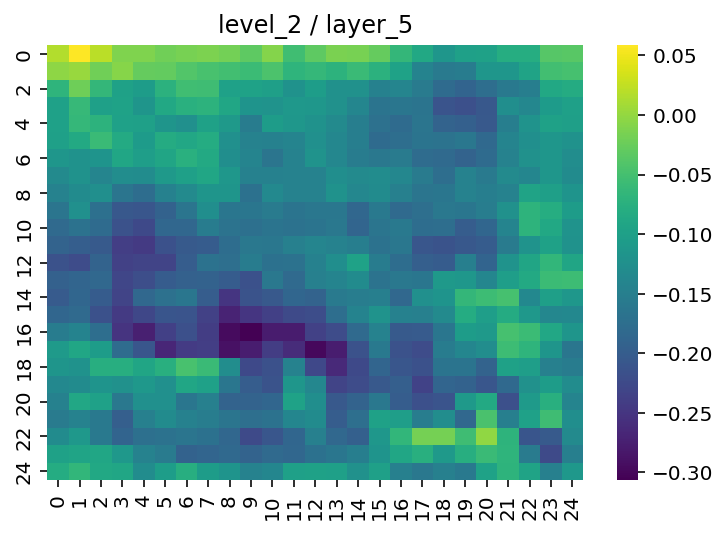

In [9]:
import seaborn as sns
import torch.nn.functional as F
encoder_layer = 5
hooking(model, encoder_layer)
split_sizes = [10000, 2500, 625, 169]
f1, f2, f3, f4 = torch.split(enc_attn_weights[0], split_sizes, dim=0)
for key, feature in conv_features.items() :
    # get the HxW shape of the feature maps of the CNN
    shape = feature.tensors.shape[-2:]
    if key == '0':
        f1 = f1.reshape(100, 100, 256)
        mean_feature = f1.mean(dim=2)
    elif key == '1' :
        f2 = f2.reshape(50, 50, 256)
        mean_feature = f2.mean(dim=2)
    elif key == '2' :
        f3 = f3.reshape(25, 25, 256)
        mean_feature = f3.mean(dim=2)
        mean_feature = F.softmax(mean_feature)
    else : mean_feature = None
    if mean_feature != None :
        sns.heatmap(mean_feature.cpu(), cmap='viridis')
        plt.title(f'level_{key} / layer_{encoder_layer}')
        plt.savefig(f'/root/Deformable-DETR/result_attention/encoder_two_stage/layer_{encoder_layer}_level_{key}.jpg')
        plt.show()
        # plt.close()
# and reshape the self-attention to a more interpretable shape
# print(enc_attn_weights[0, :].shape)
# sattn = enc_attn_weights[0].reshape(shape + shape)
# sattn = mean_f1.reshape(shape + shape)
# print("Reshaped self-attention:", sattn.shape)

# get the first attention map



Now that we have the self-attention into a more interpretable representation, let's try to visualize it.
Given that the self-attention is a very large matrix, let's start by selecting a few reference points where we will be looking at the attention.

In [ ]:
# downsampling factor for the CNN, is 32 for DETR and 16 for DETR DC5
fact = 32

# let's select 4 reference points for visualization
idxs = [(200, 200), (420, 400), (200, 600), (500, 500)]

# here we create the canvas
fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
# and we add one plot per reference point
gs = fig.add_gridspec(2, 4)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

# for each one of the reference points, let's plot the self-attention
# for that point
for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    ax.imshow(sattn[..., idx[0], idx[1]], cmap='cividis', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'self-attention{idx_o}')

# and now let's add the central image, with the reference points as red circles
fcenter_ax = fig.add_subplot(gs[:, 1:-1])
fcenter_ax.imshow(im)
for (y, x) in idxs:
    scale = im.height / img.shape[-2]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
    fcenter_ax.axis('off')

That's pretty nice! This visualization gives the intuition that the encoder might be already performing some sort of object separation thanks to the self-attention mechanism.

## Interactive visualization of self-attention
In the following cell, we wrap the above snippets into a widget so that it makes it easier to insert your own image or define the reference points for easier visualization.

### Defining the AttentionVisualizer

There is a lot of code in there, but it's mostly boilerplate so that we can have a nice demo.
Ideally, we would have enabled a click-on-the-image to get the point we want to look at, but I couldn't make it work with Colab, so we used sliders instead.

You should execute the cell below, which is hidden in order to keep everything tidy, in order to get the `AttentionVisualizer` class that we will be using afterwards.

In [ ]:
class AttentionVisualizer:
    def __init__(self, model, transform):
        self.model = model
        self.transform = transform

        self.url = ""
        self.cur_url = None
        self.pil_img = None
        self.tensor_img = None

        self.conv_features = None
        self.enc_attn_weights = None
        self.dec_attn_weights = None

        self.setup_widgets()

    def setup_widgets(self):
        self.sliders = [
            widgets.Text(
                value='http://images.cocodataset.org/val2017/000000039769.jpg',
                placeholder='Type something',
                description='URL (ENTER):',
                disabled=False,
                continuous_update=False,
                layout=widgets.Layout(width='100%')
            ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='X coordinate', value=0.72,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')
                        ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='Y coordinate', value=0.40,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')),
            widgets.Checkbox(
              value=False,
              description='Direction of self attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          ),
            widgets.Checkbox(
              value=True,
              description='Show red dot in attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          )
        ]
        self.o = widgets.Output()

    def compute_features(self, img):
        model = self.model
        # use lists to store the outputs via up-values
        conv_features, enc_attn_weights, dec_attn_weights = [], [], []

        hooks = [
            model.backbone[-2].register_forward_hook(
                lambda self, input, output: conv_features.append(output)
            ),
            model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
                lambda self, input, output: enc_attn_weights.append(output[1])
            ),
            model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
                lambda self, input, output: dec_attn_weights.append(output[1])
            ),
        ]
        # propagate through the model
        outputs = model(img)

        for hook in hooks:
            hook.remove()

        # don't need the list anymore
        self.conv_features = conv_features[0]
        self.dec_attn_weights = dec_attn_weights[0]
        # get the HxW shape of the feature maps of the CNN
        shape = self.conv_features['0'].tensors.shape[-2:]
        # and reshape the self-attention to a more interpretable shape
        self.enc_attn_weights = enc_attn_weights[0].reshape(shape + shape)
    
    def compute_on_image(self, url):
        if url != self.url:
            self.url = url
            self.pil_img = Image.open(requests.get(url, stream=True).raw)
            # mean-std normalize the input image (batch-size: 1)
            self.tensor_img = self.transform(self.pil_img).unsqueeze(0)
            self.compute_features(self.tensor_img)
    
    def update_chart(self, change):
        with self.o:
            clear_output()

            # j and i are the x and y coordinates of where to look at
            # sattn_dir is which direction to consider in the self-attention matrix
            # sattn_dot displays a red dot or not in the self-attention map
            url, j, i, sattn_dir, sattn_dot = [s.value for s in self.sliders]

            fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 4))
            self.compute_on_image(url)

            # convert reference point to absolute coordinates
            j = int(j * self.tensor_img.shape[-1])
            i = int(i * self.tensor_img.shape[-2])

            # how much was the original image upsampled before feeding it to the model
            scale = self.pil_img.height / self.tensor_img.shape[-2]

            # compute the downsampling factor for the model
            # it should be 32 for standard DETR and 16 for DC5
            sattn = self.enc_attn_weights
            fact = 2 ** round(math.log2(self.tensor_img.shape[-1] / sattn.shape[-1]))

            # round the position at the downsampling factor
            x = ((j // fact) + 0.5) * fact
            y = ((i // fact) + 0.5) * fact

            axs[0].imshow(self.pil_img)
            axs[0].axis('off')
            axs[0].add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))

            idx = (i // fact, j // fact)
            
            if sattn_dir:
                sattn_map = sattn[idx[0], idx[1], ...]
            else:
                sattn_map = sattn[..., idx[0], idx[1]]
            
            axs[1].imshow(sattn_map, cmap='cividis', interpolation='nearest')
            if sattn_dot:
                axs[1].add_patch(plt.Circle((idx[1],idx[0]), 1, color='r'))
            axs[1].axis('off')
            axs[1].set_title(f'self-attention{(i, j)}')

            plt.show()
        
    def run(self):
      for s in self.sliders:
          s.observe(self.update_chart, 'value')
      self.update_chart(None)
      url, x, y, d, sattn_d = self.sliders
      res = widgets.VBox(
      [
          url,
          widgets.HBox([x, y]),
          widgets.HBox([d, sattn_d]),
          self.o
      ])
      return res

### Using the AttentionVisualizer

Ok, phew, that was a lot of code, but how do we use it?
Just run the following cell, and it should work!

You can change the URL in the field, but don't forget to hit ENTER to submit it.
In the same way, we made the sliders only update its value once the user releases it, in order to avoid lags.

We additionally add two options for visualization:
- Direction of self-attention: the self-attention is a `[H, W, H, W]` matrix, so given a `i, j` point, we can return either `[i, j, :, :]` or `[:, :, i, j]`. This flag let's you chose how you want to visualize it
- Show red dot in attention: just adds a red dot to the self-attention image to facilitate visualization.

Give it a try!

In [ ]:
w = AttentionVisualizer(model, transform)
print(type(w))
w.run()

That's it! Now try it on your own image and see what the self-attention of the Transformer Encoder learned by itself!

# Conclusion

In this notebook, we showed:
- how to use torchhub to compute predictions on your own image,
- how to visualize the decoder inter-attention for each prediction,
- how to visualize the encoder self-attention for a given reference point.